In [472]:
# Import des fonctions et éléments

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from random import choices, randint, sample
import igraph as ig

In [473]:
# Constantes utiles
n_node = 10000
moyenne = 300

In [474]:
#Génération du graphe aléatoire
network = ig.Graph.Barabasi(n = n_node, m = moyenne,directed = True)

In [475]:
#Génération d'une liste avec poids pour choisir les individus de manière inégale

step = int(n_node/10)
weight_list = []

val = 1
count = 0
for i in range(n_node):
    count += 1
    weight_list.append(val)
    if count > step:
        count = 0
        val *= 1.3

In [476]:
# Création d'un dictionnaire résumant les informations de chaque noeuds. Les paramètres sont aléatoires

def reini_dico():
    dico = {}
    for v in network.vs:
            # initia lisation of the dictionary with basics caracterisitcs
        dico[v] = {'total_views': 0,
                            'total_likes': 0,
                            'total_comments': 0,
                            'total_click': 0,
                            'total_donations': 0,
                            'posting': 0, # first number = is posting at this timestamp, second number = will post at the next timestamp)
                            'posted': 0, # 1 if the user already posted something, turns back to 0 after a while (so that the user can post again)
                            'iterations_since_post':0,
                            'influenciability' : choices([1,2,3], weights=(30,20,10), k=1)[0],
                            'seuil_repost' : int(np.random.uniform(0,100)),
                            'nb_followers' : v.indegree()
                            }  # Parameters we consider have an impact on the post propagation
    return dico

In [477]:
# Fonction attribuant un score d'engagement à chaque utilisateur du réseau

def score(network,dico):
    # Donne le score global des individus dans le réseau
    
    score_dic = {}
    for user in dico:
        s = 0
        user_d = dico[user]
        
        view = user_d['total_views']
        likes = user_d['total_likes']
        comm = user_d['total_comments']
        click = user_d['total_click']
        donate = user_d['total_donations']
        inf = user_d['influenciability']
        
        s += view + 20*likes + 200*comm + 400*click + 4000 * donate + inf
        s *= (inf+1)/2
        
        score_dic[user] = s
    return score_dic

In [478]:
# Fonctions permettant de générer un post

def action_number(poster,dico):
    # Returns a dictionnary of the number of persons doing each action for a post from "poster"
    action_dic = {'view': 0, 'like': 0, 'comment': 0, 'click': 0, 'donate':0}
        
    followers = dico[poster]['nb_followers']
    
    
    nb_views = followers*np.random.exponential(1/1.2, 1)[0]/1.4
    nb_likes = followers*np.random.exponential(1/6, 1)[0]/1.2
    nb_comments = followers*np.random.exponential(1/30, 1)[0]/1.2
    nb_clicks = np.random.binomial(nb_views, 320/251167)

    action_dic['view'] = int(nb_views)
    action_dic['like'] = int(nb_likes)
    action_dic['comment'] = int(nb_comments)
    action_dic['click'] = int(nb_clicks)
    
    return action_dic
    
   

def post_rank(graph,poster,score_dic):    
    # Bonifie le score d'engagement des utilsiateurs s'ils followent le poster
    for key in score_dic:
        score = score_dic[key]
        if graph.are_connected(key,poster):
            score *= 2
        score_dic[key] = score
    return sorted(score_dic, key=score_dic.get, reverse=True)
    


def choose(action_dic,rank_lst):
    # Outputs the choice dictionnary where a list represents the user_ids that will do the actions
    choice_dic = {'view': [], 'like': [], 'comment': [], 'click': [], 'donate':[]}
    
    for key in choice_dic:
        if key != 'donate' :
            choice_dic[key] = choices(rank_lst,weights = weight_list,k = action_dic[key])
        else:
            click_lst = choice_dic['click']
            donate = []
            for clicker in click_lst:
                flip = choices([0,1],weights = [0.9,0.1],k = 1)[0]
                if flip == 1:
                    donate.append(clicker)
            choice_dic[key] = donate

    return choice_dic

def action_update(choice_dic,dico):
    # Updates the values of the dictionnary based on the actions done (changes second value of tuple)
    
    #vues:
    for id in choice_dic['view']:
        dico[id]['total_views']+=1
    #like:
    for id in choice_dic['like']:
        dico[id]['total_likes']+=1
    #comment:
    for id in choice_dic['comment']:
        dico[id]['total_comments']+=1
    #click:
    for id in choice_dic['click']:
        dico[id]['total_click']+=1
    #dons:
    for id in choice_dic['donate']:
        dico[id]['total_donations']+=1
        
    return dico

In [479]:
# Genere un post avec les fonctions précédentes

def post(poster,network,scores,dico):
    # Variables : vertex id, the graph, a score dictionnary, the global dictionnary
    
    action_dic = action_number(poster,dico)
    rank_lst = post_rank(network,poster,scores)
    choice_dic= choose(action_dic, rank_lst)
    dico = action_update(choice_dic,dico)
    
    return dico

In [480]:
# Fait une iteration de temps de simulation en generant tout les post

def update(dico,g):
    #Prend en argument le dictionnaire de personnes à un instant et le réseau et fait le pas de temps suivant
    general_score = score(g,dico)       #dictionnaire avec id en clé et score en valeur
    for person in dico:
        if dico[person]['posting'] == 1:
            dico = post(person,g,general_score,dico)
    
    for key in dico:
        if dico[key]['posting'] == 1:
            dico[key]['posting'] = 0
            dico[key]['posted'] = 1
        elif (dico[key]['seuil_repost'] < dico[key]['total_views']) and (dico[key]['posted'] != 1):
            dico[key]['posting'] = 1

def posts_initiaux(dico, listeid):
    for id in listeid:
        dico[id]['posting']=1
    return

In [481]:
# Cree des listes triees des utilsateurs par followers

vertex_per_follower = []
L = []
for vertex in network.vs:
    followers = vertex.indegree()
    tuple = (vertex,followers)
    L.append(tuple)
L.sort(key=lambda a: a[1])
L.reverse() #Liste de tuples triés de forme (utilisateur, nb_followers)

vertex_per_follower = [L[i][0] for i in range(len(L))] #La même liste avec seulement les utilisateurs
Liste_degree = [v.indegree() for v in vertex_per_follower] #La même liste avec seulement les followers

In [482]:
# Genère une simulation

dico = reini_dico()
list = sample(range(1000,5000),400)
vertex = [vertex_per_follower[i] for i in list]

posts_initiaux(dico,vertex)

V = []
L = []    
Co = []
CL = []
D = []
Repost = []

for t in range(30):
    num = 0
    for key in dico:
        num += dico[key]['posting'] 
    Repost.append(num)
        
    update(dico,network)
    
for key in dico:
    V.append(dico[key]['total_views'])
    L.append(dico[key]['total_likes'])
    Co.append(dico[key]['total_comments'])
    CL.append(dico[key]['total_click'])
    D.append(dico[key]['total_donations'])


[400, 34, 109, 264, 158, 336, 860, 1596, 2397, 2059, 936, 402, 195, 172, 39, 13, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
9975


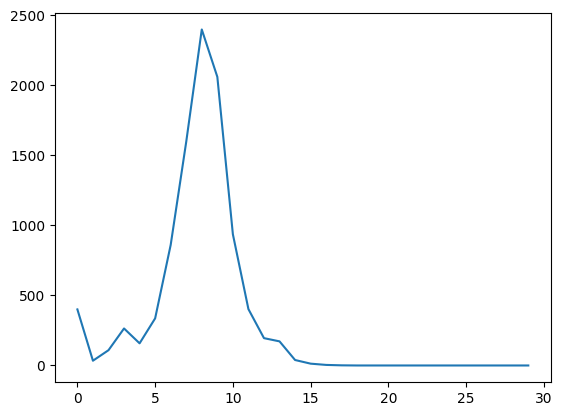

sommme totales
1899084
394277
74458
2544
235


In [483]:
print(Repost)
print(sum(Repost))
plt.plot(Repost[:30])
plt.show()

print('sommme totales')
print(sum(V))
print(sum(L))
print(sum(Co))
print(sum(CL))
print(sum(D))

# plt.hist(V)
#plt.show()

In [484]:
#Simulations pour calcule la probabilite de viralite pour differentes situations

# range : 0 - 10k -> 0 - 170 euros
# 8000 et 5000 : 0 - 320, 
# 5000 - 2000 : 321 - 400
# 2000 - 1000 : 401 - 460
# 1000 - 500 : 461 -  550


# COMMENT FAIRE :
# Choisir une colonne du sheet (a - b)
a = 461
b = 550

# Choisir une précision 
p = 50

#CHoisir les ligne que l'on veut faire
min_l = 1
max_l = 50

# Votre résultat sera de la forme (0.p, n). Veuillez remplir la ligne correspondant de la colonne avec la valeur p
# Merci :)


def viral(ini_lst):
    dico = reini_dico()

    posts_initiaux(dico,ini_lst)
    bol = True
    n = 0
    
    while bol:
        n += 1

        if n > 6:
            return True
        update(dico,network)

        num = 0
        for key in dico:
            num += dico[key]['posting'] 
        if num == 0:
            return False
        if num > 250:
            return True

def prob_virality(a,b,n):
    s = 0
    num = 0
    for i in range(p):
        num += 1
        list = sample(range(a,b+1),n)
        vertex = [vertex_per_follower[i] for i in list]
        
        s += int(viral(vertex))
    return s/num    

def prob_virality_inter(a,b):
    L = []
    for n in range(min_l,max_l + 1):
        print(n)
        L.append((prob_virality(a,b,n),n))
        print(L[-1][0])
    return L
    
print(prob_virality_inter(a,b))

            

1
0.06
2


KeyboardInterrupt: 